In [74]:
import pickle
from collections import defaultdict
# warnings.filterwarnings('ignore')
import sklearn as sk
import pandas as pd
pd.options.display.max_colwidth = 1500
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn import svm
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from datetime import datetime
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import string
import datetime
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import csv
import json
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random



In [45]:
csv_file_text = '/Users/bidishadasbaksi/Docs_no_icloud/Documents – Bidisha’s MacBook Pro/ Personal_docs Intuit Laptop/USC Journey/Spring 2022/CSCI-535 Multimodal/Project/segmented/feature_combined.csv'


In [46]:
df = pd.read_csv(csv_file_text,header=None)
df = df[(df[70]== 'D') | (df[70]== 'Ah') | (df[70]== 'Ih') | (df[70]== 'Z') | (df[70]== 'W') | (df[70]== '0')  ]
unique_classes = df[70].unique().tolist()
unique_classes.remove('0')
indexes = [i for i in range(len(unique_classes))]
replace_dict = {unique_classes[i]:i for i in indexes}
replace_dict['0']=len(unique_classes)
df[[70]] = df[[70]].replace(replace_dict)                                                              
                                                              

In [49]:
df_list  = df.values.tolist()
df_list_n_x = list()
df_l_sub_x=list()
df_list_n_y = list()
df_l_sub_y=list()
for i in df_list:
    if(i[0]!=0):
        l = i[1:len(i)-1]
        l.insert(0,float(i[0]))
        df_l_sub_x.append(l)
        df_l_sub_y.append(i[len(i)-1])
    else:
        if(len(df_l_sub_x)>0):
            df_list_n_x.append(df_l_sub_x)
            df_list_n_y.append(df_l_sub_y)
        df_l_sub_x=list()
        df_l_sub_y=list()

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(df_list_n_x, df_list_n_y, test_size=0.33, random_state=12)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=123)





In [51]:
word_dict=dict()
word_dict['<PAD>'] = 10

In [52]:
class Dataset(Dataset):
    def __init__(self, data,label):
        'Initialization'
        dim_size = len(data[0][0])
        data_lengths= [len(frame) for frame in data]
        data_lengths_copy = [len(frame) for frame in data]
        data_lengths_copy.sort()
        pad_token = word_dict['<PAD>']
        longest_frame = data_lengths_copy[-2]
        print(longest_frame)
        b_s = len(data_lengths)
        padded_X = np.ones((b_s, longest_frame,dim_size)) * pad_token
        padded_Y = np.ones((b_s,longest_frame)) * pad_token
        
        print(padded_X.shape)
        print(len(data_lengths))
        for i, d_len in enumerate(data_lengths):
            sequence = data[i]
            sequence_y = label[i]
#             if(d_len>longest_frame):
            if(d_len>longest_frame):
                continue
#             print(i)
#             print(sequence)
            
            padded_X[i, (longest_frame-d_len):] = sequence[:longest_frame]
            padded_Y[i,(longest_frame-d_len):] = sequence_y[:longest_frame]
        self.data = torch.Tensor(padded_X)
        self.label = torch.LongTensor(padded_Y)
        self.original_data = data
        self.original_label = label
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        X= self.data[index]
        y = self.label[index]
        return (X, y)

In [53]:
train_data = Dataset( X_train,Y_train)
val_data = Dataset(X_val,Y_val)
test_data = Dataset(X_test,Y_test)

125
(1795, 125, 70)
1795
98
(599, 98, 70)
599
104
(1180, 104, 70)
1180


In [54]:
train_data.label.shape

torch.Size([1795, 125])

In [55]:
num_train = len(X_train)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)



num_dev = len(X_val)
indices_dev = list(range(num_dev))
np.random.shuffle(indices_dev)

train_sampler = SubsetRandomSampler(indices_train)
dev_sampler = SubsetRandomSampler(indices_dev)

batch_size=8

train_loader= torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=0,)
dev_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
    sampler=dev_sampler, num_workers=0)


dev_loader_without_sampler = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=0)


test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=0)


In [56]:
test_loader_one = torch.utils.data.DataLoader( test_data, batch_size=1, num_workers=0)


In [57]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [58]:
class GRUNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, hidden = self.rnn(x, hidden)
        tag_space = self.fc(out)
        tag_scores = F.log_softmax(tag_space, dim=2)
        return tag_scores.view(batch_size*len(x[0]),-1)
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [59]:
new_model = GRUNet(70,6,30,1)
new_model.load_state_dict(torch.load('grunet_early_v2.pt'))

<All keys matched successfully>

In [60]:
loss_function_glove = nn.CrossEntropyLoss(ignore_index=word_dict['<PAD>'])
optimizer_glove = optim.SGD(new_model.parameters(), lr= 0.1 )
scheduler_glove = optim.lr_scheduler.ReduceLROnPlateau(optimizer_glove,  mode='min',patience=3,factor=0.9)


In [61]:
best_valid_loss = float(100)

In [25]:
def train_rnn(new_model,best_valid_loss):
    for epoch in range(100):  
        train_loss = 0.0
        valid_loss = 0.0
        new_model.train()
        for dataset, target in train_loader:
            new_model.zero_grad()
            tag_scores = new_model(dataset)
            target = target.view(target.shape[0]*len(dataset[0]))
            loss = loss_function_glove(tag_scores,target)
            loss.backward()
            optimizer_glove.step()
            train_loss += loss.item()*dataset.size(0)
        new_model.eval() 
        with torch.no_grad():
            for dataset, target in dev_loader:
                tag_scores = new_model(dataset)
                target = target.view(target.shape[0]*len(dataset[0]))
                loss = loss_function_glove(tag_scores,target)
                valid_loss += loss.item()*dataset.size(0)
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(dev_loader.dataset)
        print('Time: {} \tEpoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                    datetime.datetime.now(),
                    epoch+1, 
                    train_loss,
                    valid_loss
                    ))
        if(valid_loss < best_valid_loss):
            best_valid_loss = valid_loss
            torch.save(new_model.state_dict(), 'grunet_early_v2.pt')
        scheduler_glove.step(valid_loss)
    return best_valid_loss

In [ ]:
best_valid_loss = train_rnn(new_model,best_valid_loss)

In [62]:
def predict(model, dataloader):
    prediction_list = []
    test_data_list = []
    for data, target in dataloader:
        outputs = model(data)
        for i,dat in enumerate(outputs.data):
            predicted = torch.argmax(dat)
            if(target[0][i]!=torch.tensor(word_dict['<PAD>']) ):
                prediction_list.append(predicted)
                test_data_list.append(target[0][i])
    return (test_data_list,prediction_list)

In [65]:
predictions = predict(new_model,test_loader_one)

In [66]:
pred = np.array(predictions[1])
targ = np.array(predictions[0])


## Accuracy

In [67]:
metrics.accuracy_score(targ, pred)


0.6670715505788575

## F1 score

In [68]:
metrics.f1_score(targ, pred,average='weighted')


0.668161950276076

## Confusion Matrix

In [69]:
metrics.confusion_matrix(targ, pred)

array([[3116,    0,    0, 3124,    0],
       [   1, 2923,    0, 2911,    0],
       [   0,    0, 1424, 1409,    0],
       [   1,    0,    0, 8653,    0],
       [   0,    0,    0, 1325, 1458]])

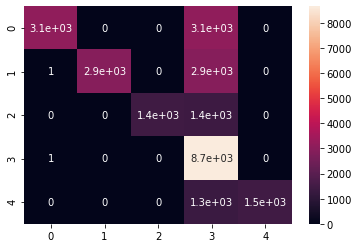

In [70]:
conf = metrics.confusion_matrix(targ, pred)
df = pd.DataFrame(conf, range(5), range(5))
sns.heatmap(df, annot=True)
plt.show()

In [71]:
def calculate_acc_per_class(confusion_matrix):
    classes_ = []
    f1_score = []
    for class_ in range(5):
        classes_k = {}
        fp = 0
        fn = 0
        tn = 0
        for i in range(len(confusion_matrix)):
            for j in range(len(confusion_matrix[i])):
                if (i == j) and (i==class_):
                    classes_k['tp'] = confusion_matrix[i][j]
                elif (i == class_):
                    fp += confusion_matrix[i][j]
                elif (j == class_):
                    fn += confusion_matrix[i][j]
                else:
                    tn += confusion_matrix[i][j]
        classes_k['tn'] = tn
        classes_k['fp'] = fp
        classes_k['fn'] = fn
        classes_k['precision'] = classes_k['tp']/(classes_k['tp'] + fp)
        classes_k['recall'] = classes_k['tp']/(classes_k['tp'] + fn)
        classes_k['f1_score'] =(2* classes_k['precision']  * classes_k['recall']) /(classes_k['precision']  + classes_k['recall'] )
        f1_score.append(classes_k['f1_score'])
        classes_.append(classes_k) 
    f1_score_macro = sum(f1_score)/len(f1_score)
    return classes_, f1_score_macro

In [72]:
res = calculate_acc_per_class(conf)

In [73]:
res

([{'tp': 3116,
   'tn': 20103,
   'fp': 3124,
   'fn': 2,
   'precision': 0.49935897435897436,
   'recall': 0.9993585631815266,
   'f1_score': 0.6659542637315665},
  {'tp': 2923,
   'tn': 20510,
   'fp': 2912,
   'fn': 0,
   'precision': 0.500942587832048,
   'recall': 1.0,
   'f1_score': 0.6675039963461977},
  {'tp': 1424,
   'tn': 23512,
   'fp': 1409,
   'fn': 0,
   'precision': 0.5026473702788563,
   'recall': 1.0,
   'f1_score': 0.6690157387831807},
  {'tp': 8653,
   'tn': 8922,
   'fp': 1,
   'fn': 8769,
   'precision': 0.9998844464987289,
   'recall': 0.49667087590402936,
   'f1_score': 0.6636754103390091},
  {'tp': 1458,
   'tn': 23562,
   'fp': 1325,
   'fn': 0,
   'precision': 0.523895077254761,
   'recall': 1.0,
   'f1_score': 0.6875736854515444}],
 0.6707446189302997)